In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/spidermines/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import resnet152, ResNet152_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
import pickle
from tqdm import tqdm
import cv2
from torch.cuda.amp import GradScaler, autocast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer, scoring
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pwd
# %cd /content/drive/MyDrive/DL_Project/
# !pwd

In [ ]:
# !unzip glove.zip

In [ ]:
# !unzip archive.zip

In [ ]:
images_folder = 'dataset/images/images_normalized/'
projections_path = 'dataset/indiana_projections.csv'
reports_path = 'dataset/indiana_reports.csv'
glove_path='dataset/glove/glove.6B.200d.txt'

# images_folder = 'images/images_normalized/'
# projections_path = 'indiana_projections.csv'
# reports_path = 'indiana_reports.csv'
# glove_path='glove.6B.200d.txt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Load ClinicalBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalbert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
clinicalbert_model.eval()  # Set to evaluation mode

/home/spidermines/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Data Loading and Preprocessing

In [ ]:
def clean_report(report):
    # Remove short words and non-alphabetic characters, then lowercase
    report = re.sub(r'\b\w{1,2}\b', '', report)
    report = re.sub(r'[^a-zA-Z\s]', '', report)
    report = report.lower()
    return report

In [ ]:
def load_indiana_dataset(projections_path, reports_path, images_folder):
    # Load CSV files
    projections = pd.read_csv(projections_path)
    reports = pd.read_csv(reports_path)

    image_paths = []
    reports_text = []
    projections_list = []

    # Iterate through each projection entry
    for idx, row in projections.iterrows():
        image_id = row['filename']
        uid = row['uid']
        projection = row['projection']  # Extract projection type

        # Retrieve the corresponding report using uid
        report_row = reports[reports['uid'] == uid]

        if not report_row.empty:
            # Combine relevant report sections
            report_sections = ['findings', 'impression', 'indication']
            combined_report = ' '.join([
                str(report_row.iloc[0][section])
                for section in report_sections
                if pd.notnull(report_row.iloc[0][section])
            ])
            # Clean the combined report
            cleaned_report = clean_report(combined_report)
            # Append to respective lists
            image_paths.append(os.path.join(images_folder, image_id))
            reports_text.append(cleaned_report)
            projections_list.append(projection)

    return image_paths, reports_text, projections_list

In [ ]:
image_paths, reports_text, projections_list = load_indiana_dataset(projections_path, reports_path, images_folder)

In [ ]:
reports_text[0]

'the cardiac silhouette and mediastinum size are within normal limits there   pulmonary edema there   focal consolidation there are  xxxx   pleural effusion there   evidence  pneumothorax normal chest xxxx positive  test'

In [ ]:
image_paths[0]

'dataset/images/images_normalized/1_IM-0001-4001.dcm.png'

In [ ]:
print(f"Total images: {len(image_paths)}")
print(f"Total reports: {len(reports_text)}")
print(f"Total projections: {len(projections_list)}")

Total images: 7466
Total reports: 7466
Total projections: 7466


# Vocabulary Creation and GloVe Embeddings

In [ ]:
def create_vocabulary(reports, threshold=10):
    from collections import Counter
    words = []
    for report in reports:
        tokens = nltk.word_tokenize(report)
        words.extend(tokens)

    word_counts = Counter(words)
    vocab = [word for word, count in word_counts.items() if count >= threshold]

    # Special tokens
    vocab = ['<pad>', '<unk>', '<start>', '<end>'] + vocab

    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}

    return word_to_index, index_to_word


In [ ]:
# Create vocabulary
word_to_index, index_to_word = create_vocabulary(reports_text, threshold=3)
vocab_size = len(word_to_index)
print(f"Vocabulary Size: {vocab_size}")

# Save the vocabulary mappings for future use
with open("word_to_index.pkl", "wb") as f:
    pickle.dump(word_to_index, f)
    print("Saved 'word_to_index.pkl' successfully.")

with open("index_to_word.pkl", "wb") as f:
    pickle.dump(index_to_word, f)
    print("Saved 'index_to_word.pkl' successfully.")

Vocabulary Size: 1783
Saved 'word_to_index.pkl' successfully.
Saved 'index_to_word.pkl' successfully.


In [ ]:
print(f"Sample word_to_index mappings: {list(word_to_index.items())[:10]}")
print(f"Sample index_to_word mappings: {list(index_to_word.items())[:10]}")

Sample word_to_index mappings: [('<pad>', 0), ('<unk>', 1), ('<start>', 2), ('<end>', 3), ('the', 4), ('cardiac', 5), ('silhouette', 6), ('and', 7), ('mediastinum', 8), ('size', 9)]
Sample index_to_word mappings: [(0, '<pad>'), (1, '<unk>'), (2, '<start>'), (3, '<end>'), (4, 'the'), (5, 'cardiac'), (6, 'silhouette'), (7, 'and'), (8, 'mediastinum'), (9, 'size')]


In [ ]:
def get_clinicalbert_embeddings(reports, tokenizer, model, device, max_length=128):
    # Ensure that reports is a list of strings
    if not isinstance(reports, list):
        raise ValueError("reports must be a list of strings.")

    encoded_inputs = tokenizer(
        reports,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoded_inputs)
        # Use the [CLS] token representation as the aggregated embedding
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_dim)

    return cls_embeddings  # (batch_size, hidden_dim)


In [ ]:
def load_glove_embeddings(embedding_path, word_to_index, embedding_dim=200):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    # Initialize embedding matrix with random vectors
    embedding_matrix = np.random.normal(scale=0.6, size=(len(word_to_index), embedding_dim))

    # Replace random vectors with GloVe vectors where available
    for word, idx in word_to_index.items():
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float32)


In [ ]:
embedding_dim = 200
embedding_matrix = load_glove_embeddings(glove_path, word_to_index, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: torch.Size([1783, 200])


In [ ]:
print(f"Sample Embedding for '<pad>': {embedding_matrix[word_to_index['<pad>']]}")
print(f"Sample Embedding for 'normal': {embedding_matrix[word_to_index['normal']]}")

Sample Embedding for '<pad>': tensor([-0.1517, -0.0927,  1.0898, -0.0512,  0.5530,  0.6824,  0.6095, -0.2829,
        -0.9606, -0.0531, -0.3803,  0.6914,  0.3369,  0.2963,  0.8142, -1.6402,
        -1.5271, -0.7544, -0.1970, -0.1434,  0.1034,  0.8984, -0.6229, -1.2532,
         0.4099, -0.3291,  0.0968,  0.6383,  0.9810,  0.1693,  0.0260, -0.9296,
         0.1714, -0.1424,  0.7571, -0.0726,  0.3040, -0.1922, -0.8741,  0.2508,
         0.3804, -0.0690,  1.0116,  0.3523,  0.6044,  0.9542,  0.6369,  1.1296,
        -0.0136, -0.9441, -0.4365,  0.4036, -0.4779, -0.3631,  0.6627,  0.1593,
        -0.2707,  0.2493,  0.3220,  0.2094,  0.9092,  0.0754,  0.2329, -0.1105,
        -0.1214, -0.7166, -0.3043, -0.5159,  1.1174,  0.4321,  0.8053, -1.1562,
        -0.3338,  0.3507, -0.4174,  0.2052, -0.6158,  0.3745,  0.6435, -0.7918,
        -0.4061,  0.1698,  0.0057,  0.0141,  0.3878, -1.5918, -0.2062, -0.3729,
        -0.2949,  0.4439, -0.8965, -0.9458,  0.2992,  0.7896,  0.4837,  0.4511,
        -0

# Custom Dataset and DataLoaders

In [ ]:
class IndianaDataset(Dataset):
    def __init__(self, image_paths, reports, projections, word_to_index, max_length, transform=None):
        self.image_paths = image_paths
        self.reports = reports
        self.projections = projections
        self.transform = transform
        self.word_to_index = word_to_index
        self.max_length = max_length

        # Create a sorted list of unique projection types
        self.projection_types = sorted(list(set(projections)))
        self.projection_to_index = {proj: idx for idx, proj in enumerate(self.projection_types)}
        self.index_to_projection = {idx: proj for proj, idx in self.projection_to_index.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize the report
        report = self.reports[idx]
        tokens = nltk.word_tokenize(report)
        tokens = [self.word_to_index.get(word, self.word_to_index['<unk>']) for word in tokens]

        # Add <start> and <end> tokens
        tokens = [self.word_to_index['<start>']] + tokens + [self.word_to_index['<end>']]

        # Pad or truncate tokens to max_length
        if len(tokens) < self.max_length:
            tokens += [self.word_to_index['<pad>']] * (self.max_length - len(tokens))
        else:
            tokens = tokens[:self.max_length]

        tokens = torch.tensor(tokens, dtype=torch.long)

        # Encode projection
        projection = self.projections[idx]
        projection_idx = self.projection_to_index.get(projection, len(self.projection_types))  # Handle unknown projections
        projection_tensor = torch.tensor(projection_idx, dtype=torch.long)

        # Retrieve the actual report text
        report_text = self.reports[idx]

        return image, tokens, projection_tensor, report_text


In [ ]:
def custom_collate(batch):
    images, tokens, projections, report_texts = zip(*batch)
    images = torch.stack(images, dim=0)
    tokens = torch.stack(tokens, dim=0)
    projections = torch.stack(projections, dim=0)
    report_texts = list(report_texts)  # Convert tuple to list
    return images, tokens, projections, report_texts


In [ ]:
# Define maximum caption length
max_sequence_length = 128

In [ ]:
# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
train_paths, temp_paths, train_reports, temp_reports, train_projections, temp_projections = train_test_split(
    image_paths, reports_text, projections_list, test_size=0.2, random_state=42
)

val_paths, test_paths, val_reports, test_reports, val_projections, test_projections = train_test_split(
    temp_paths, temp_reports, temp_projections, test_size=0.5, random_state=42
)

In [ ]:
print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Test set size: {len(test_paths)}")

Training set size: 5972
Validation set size: 747
Test set size: 747


In [ ]:
train_dataset = IndianaDataset(train_paths, train_reports, train_projections, word_to_index, max_sequence_length, transform=train_transform)
val_dataset = IndianaDataset(val_paths, val_reports, val_projections, word_to_index, max_sequence_length, transform=val_test_transform)
test_dataset = IndianaDataset(test_paths, test_reports, test_projections, word_to_index, max_sequence_length, transform=val_test_transform)

In [ ]:
batch_size = 16

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate
)


# Model Architectures CNN-LSTM

In [ ]:
class ImprovedCNNEncoder(nn.Module):
    def __init__(self, embed_dim=200):
        super(ImprovedCNNEncoder, self).__init__()
        self.resnet = nn.Sequential(*list(models.resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-1])
        self.fc = nn.Linear(2048, embed_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.dropout(self.relu(self.fc(features)))
        return features

In [ ]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        super(LuongAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(hidden))
        attention = self.v(energy)
        attn_weights = torch.softmax(attention, dim=1)
        context = encoder_output * attn_weights
        return context, attn_weights

In [ ]:
class HierarchicalLSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, embedding_matrix, num_layers=1, dropout=0.5, clinical_embed_dim=768):
        super(HierarchicalLSTMDecoder, self).__init__()

        # Word Embedding (200)
        self.embed = nn.Embedding(vocab_size, embed_dim // 2)  # 400 // 2 = 200
        self.embed.weight = nn.Parameter(embedding_matrix)
        self.embed.weight.requires_grad = True  # Allow fine-tuning embeddings

        # Projection Layer to map 200 -> 400
        self.proj = nn.Linear(embed_dim // 2, embed_dim)

        # ClinicalBERT embedding projection
        self.clinical_proj = nn.Linear(clinical_embed_dim, embed_dim)

        self.attention = LuongAttention(hidden_dim, attn_dim=hidden_dim)

        self.lstm = nn.LSTM(embed_dim * 2, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Update in_features to hidden_dim + 400
        self.fc = nn.Linear(hidden_dim + 400, vocab_size)  # Correct in_features
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, encoder_output, clinical_embeddings, hidden=None):
        # Embed captions
        embeddings = self.embed(captions)
        embeddings = self.proj(embeddings)
        embeddings = self.dropout(embeddings)

        # Project ClinicalBERT embeddings
        clinical_proj = self.clinical_proj(clinical_embeddings)
        clinical_proj = clinical_proj.unsqueeze(1)
        clinical_proj = self.dropout(clinical_proj)

        # Concatenate word embeddings with ClinicalBERT embeddings
        embeddings = torch.cat((embeddings, clinical_proj.repeat(1, embeddings.size(1), 1)), dim=2)

        # Pass through LSTM
        outputs, hidden = self.lstm(embeddings, hidden)

        # Apply Attention
        attention_context, attn_weights = self.attention(hidden[0][-1], encoder_output)
        attention_context = attention_context.unsqueeze(1)

        # Concatenate attention context with LSTM outputs
        combined = torch.cat((outputs, attention_context.repeat(1, outputs.size(1), 1)), dim=2)

        # Generate predictions
        preds = self.fc(combined)

        return preds, hidden


In [ ]:
class ImprovedCNNLSTMModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, embedding_matrix, clinicalbert_model, num_layers=2, dropout=0.5, projection_size=2, clinical_embed_dim=768):
        super(ImprovedCNNLSTMModel, self).__init__()
        self.encoder = ImprovedCNNEncoder(embed_dim=embed_dim)

        # Projection Embedding
        self.projection_embed = nn.Embedding(projection_size, embed_dim)

        # ClinicalBERT
        self.clinicalbert_model = clinicalbert_model

        # Decoder expects concatenated image features and projection embeddings
        self.decoder = HierarchicalLSTMDecoder(
            embed_dim=embed_dim * 2,  # 200 * 2 = 400
            hidden_dim=hidden_dim,
            vocab_size=vocab_size,
            embedding_matrix=embedding_matrix,
            num_layers=num_layers,
            dropout=dropout,
            clinical_embed_dim=clinical_embed_dim
        )

    def forward(self, images, captions, projections, reports_text=None, device=None, hidden=None):
        # Encode images
        encoder_outputs = self.encoder(images)

        # Embed projections
        projection_embedding = self.projection_embed(projections)

        # Concatenate image features with projection embeddings
        combined_features = torch.cat((encoder_outputs, projection_embedding), dim=1)

        # Generate ClinicalBERT embeddings if reports_text is provided
        if reports_text is not None:
            clinical_embeddings = get_clinicalbert_embeddings(reports_text, tokenizer, self.clinicalbert_model, device)
        else:
            # Initialize ClinicalBERT embeddings as zero vectors during inference
            clinical_embeddings = torch.zeros(images.size(0), 768).to(device)

        # Pass to decoder
        outputs, hidden = self.decoder(captions, combined_features, clinical_embeddings, hidden)
        return outputs, hidden


# Training and Evaluation Functions CNN-LSTM

In [ ]:
scaler = GradScaler()

/tmp/ipykernel_6352/4292142752.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def train_cnn_lstm_model(model, dataloader, criterion, optimizer, num_epochs, device,
                         checkpoint_path='cnn_lstm_ckpt.pth', scheduler=None,
                         early_stopping_patience=10, start_epoch=1, accumulation_steps=4):

    model.to(device)
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    scaler = GradScaler()

    for epoch in range(start_epoch, num_epochs + 1):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")
        optimizer.zero_grad()
        for i, batch in enumerate(progress_bar):
            images, captions, projections, reports_text_batch = batch
            images = images.to(device)
            captions = captions.to(device)
            projections = projections.to(device)

            with autocast():
                # Forward pass with ground truth reports for ClinicalBERT embeddings
                outputs, hidden = model(images, captions, projections, reports_text_batch, device)

                # Shift outputs and labels for alignment
                outputs = outputs[:, :-1, :].reshape(-1, outputs.size(-1))
                labels = captions[:, 1:].reshape(-1)

                # Compute loss
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps

            # Backward pass with scaler
            scaler.scale(loss).backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # Accumulate loss
            epoch_loss += loss.item() * accumulation_steps
            progress_bar.set_postfix(loss=loss.item() * accumulation_steps)

        # Handle remaining gradients
        if len(dataloader) % accumulation_steps != 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

        # Scheduler step
        if scheduler:
            scheduler.step(avg_epoch_loss)

        # Check for improvement
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': avg_epoch_loss
            }, checkpoint_path)
            print(f"New best model saved at epoch {epoch}.")
        else:
            patience_counter += 1
            print(f"No improvement in loss for {patience_counter} epoch(s).")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    print("Training completed.")


In [ ]:
def evaluate_cnn_lstm_model(model, dataloader, index_to_word, word_to_index, device, model_name="CNN-LSTM"):

    model.to(device)
    model.eval()
    all_reports = []
    all_generated_reports = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            images, captions, projections, reports_text_batch = batch  # Unpack report texts
            images = images.to(device)
            projections = projections.to(device)

            # Generate ClinicalBERT embeddings
            clinical_embeddings = get_clinicalbert_embeddings(reports_text_batch, tokenizer, model.clinicalbert_model, device)

            # Initialize captions with <start> token
            batch_size = images.size(0)
            input_captions = torch.tensor([[word_to_index['<start>']] for _ in range(batch_size)], dtype=torch.long).to(device)

            generated_captions = [[] for _ in range(batch_size)]

            # Set max length
            max_length = max_sequence_length  # Same as training

            for _ in range(max_length):
                outputs, hidden = model(images, input_captions, projections, reports_text_batch, device)
                preds = outputs[:, -1, :].argmax(dim=-1)
                for i in range(batch_size):
                    generated_captions[i].append(preds[i].item())
                input_captions = torch.cat((input_captions, preds.unsqueeze(1)), dim=1)

            # Convert generated captions to text
            for i in range(batch_size):
                words = []
                for idx in generated_captions[i]:
                    word = index_to_word.get(idx, '<unk>')
                    if word in ['<end>', '<pad>']:
                        break
                    words.append(word)
                generated_report = ' '.join(words)
                all_generated_reports.append(generated_report)

            # Convert actual captions to text
            for i in range(batch_size):
                words = []
                for idx in captions[i]:
                    word = index_to_word.get(idx.item(), '<unk>')
                    if word in ['<end>', '<pad>']:
                        break
                    if word == '<start>':
                        continue
                    words.append(word)
                actual_report = ' '.join(words)
                all_reports.append(actual_report)

    # Compute BLEU scores with smoothing
    smoothing = SmoothingFunction().method1
    bleu_scores = [
        sentence_bleu(
            [ref.split()],
            hyp.split(),
            smoothing_function=smoothing
        )
        for ref, hyp in zip(all_reports, all_generated_reports)
    ]
    avg_bleu = np.mean(bleu_scores)
    print(f"\n{model_name} BLEU Score: {avg_bleu:.4f}")

    # Compute ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()

    for ref, hyp in zip(all_reports, all_generated_reports):
        scores = scorer.score(ref, hyp)
        aggregator.add_scores(scores)

    result = aggregator.aggregate()
    print(f"{model_name} ROUGE-1 F1: {result['rouge1'].mid.fmeasure:.4f}")
    print(f"{model_name} ROUGE-2 F1: {result['rouge2'].mid.fmeasure:.4f}")
    print(f"{model_name} ROUGE-L F1: {result['rougeL'].mid.fmeasure:.4f}")



# Model Initialization CNN-LSTM



In [ ]:
embed_dim = 200
hidden_dim = 512
projection_size = len(train_dataset.projection_types) + 1
clinical_embed_dim = 768

In [ ]:
cnn_lstm_model = ImprovedCNNLSTMModel(
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    embedding_matrix=embedding_matrix,
    clinicalbert_model=clinicalbert_model,
    num_layers=2,
    dropout=0.5,
    projection_size=projection_size,
    clinical_embed_dim=clinical_embed_dim
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<pad>'], label_smoothing=0.1)
optimizer = optim.AdamW(cnn_lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)


# Training the Models CNN-LSTM

In [ ]:
num_epochs=50
start_epoch = 1
checkpoint_path='cnn_lstm_ckpt.pth'

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='linear'
)

In [ ]:
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from '{checkpoint_path}'...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    cnn_lstm_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint: Epoch {checkpoint['epoch']}, Loss {checkpoint['loss']:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Loading checkpoint from 'cnn_lstm_ckpt.pth'...


/tmp/ipykernel_6352/120194060.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint: Epoch 50, Loss 2.8696


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

12

In [ ]:
# Train CNN-LSTM Model
print("Training Improved CNN-LSTM Model...")
train_cnn_lstm_model(
    model=cnn_lstm_model,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path=checkpoint_path,
    scheduler=scheduler,
    early_stopping_patience=10,
    start_epoch=start_epoch,
    accumulation_steps=1
)

Training Improved CNN-LSTM Model...
Training completed.


In [ ]:
# Evaluate CNN-LSTM Model
print("\nEvaluating Improved CNN-LSTM Model...")
evaluate_cnn_lstm_model(
    model=cnn_lstm_model,
    dataloader=val_loader,
    index_to_word=index_to_word,
    word_to_index=word_to_index,
    model_name="Improved CNN-LSTM with ClinicalBERT",
    device=device
)

Evaluating Improved CNN-LSTM Model...
Evaluating Improved CNN-LSTM: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [23:37<00:00, 30.15s/it]
Improved CNN-LSTM BLEU Score: 0.3645
Improved CNN-LSTM ROUGE-1 F1: 0.5414
Improved CNN-LSTM ROUGE-2 F1: 0.3937
Improved CNN-LSTM ROUGE-L F1: 0.4476


In [ ]:
def prepare_image(image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    return image

In [ ]:
def generate_caption_beam_search_with_clinicalbert(
    model,
    image,
    projection,
    index_to_word,
    word_to_index,
    device,
    tokenizer,
    max_length=128,
    beam_width=5,
    repetition_penalty=1.5
):
    model.eval()
    with torch.no_grad():
        # Initialize the beam with the start token
        start_token = word_to_index.get('<start>', 0)
        beams = [([start_token], 0.0, None, [])]

        # Initialize ClinicalBERT embedding cache
        embedding_cache = defaultdict(lambda: torch.zeros(1, 768).to(device))  # Default to zero embeddings

        for step in range(max_length):
            all_candidates = []
            unique_sequences = []
            sequence_to_beam = {}
            for beam in beams:
                seq, score, hidden, generated_words = beam
                if seq[-1] == word_to_index.get('<end>', 0):
                    all_candidates.append(beam)
                    continue
                generated_text = ' '.join([index_to_word.get(idx, '<unk>') for idx in generated_words])
                unique_sequences.append(generated_text)
                sequence_to_beam[generated_text] = (seq, score, hidden, generated_words)

            # Remove duplicates and generate embeddings in batch
            unique_sequences = list(set(unique_sequences))
            clinical_embeddings_batch = get_clinicalbert_embeddings(unique_sequences, tokenizer, model.clinicalbert_model, device)

            # Update cache
            for i, seq_text in enumerate(unique_sequences):
                embedding_cache[seq_text] = clinical_embeddings_batch[i]

            # Iterate through beams
            for generated_text, beam_data in sequence_to_beam.items():
                seq, score, hidden, generated_words = beam_data
                clinical_embeddings = embedding_cache[generated_text].unsqueeze(0)

                # Prepare the input sequence
                input_seq = torch.tensor([seq], dtype=torch.long).to(device)

                # Prepare projection tensor (shape: (1,))
                projection_batch = projection

                # Forward pass with device passed correctly
                outputs, hidden = model(
                    images=image,
                    captions=input_seq,
                    projections=projection_batch,
                    reports_text=[generated_text],
                    device=device
                )

                logits = outputs[:, -1, :]
                probs = torch.log_softmax(logits, dim=-1)

                # Apply repetition penalty
                recent_words = set(generated_words[-5:])
                for word_idx in recent_words:
                    probs[0, word_idx] /= repetition_penalty

                # Select top beam_width candidates
                topk_probs, topk_indices = probs.topk(beam_width)

                # Iterate through top candidates
                for i in range(beam_width):
                    next_word = topk_indices[0, i].item()
                    next_score = score + topk_probs[0, i].item()
                    new_seq = seq + [next_word]
                    new_generated_words = generated_words + [next_word]

                    # Clone hidden state to avoid in-place modifications
                    if hidden is not None:
                        new_hidden = (hidden[0].clone(), hidden[1].clone())
                    else:
                        new_hidden = None

                    all_candidates.append((new_seq, next_score, new_hidden, new_generated_words))

            # Order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            # Select the top beam_width sequences
            beams = ordered[:beam_width]

            # Early termination if all beams have reached <end>
            if all([seq[-1] == word_to_index.get('<end>', 0) for seq, _, _, _ in beams]):
                break

        # Select the sequence with the highest score
        best_seq, best_score, _, best_generated_words = beams[0]

        # Convert indices to words
        words = [index_to_word.get(idx, '<unk>') for idx in best_seq]

        # Remove <start>, <end>, and <pad> tokens and handle placeholders
        words = [word for word in words if word not in ['<start>', '<end>', '<pad>'] and 'xxxx' not in word]

        # Join words to form the caption
        caption = ' '.join(words)
        return caption

In [ ]:
df = pd.read_csv(projections_path)
filtered_df = df[df['projection'] == 'Frontal']
test_images = list(filtered_df[['filename', 'projection']].itertuples(index=False, name=None))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Projection: Frontal
Generated Report:
both lungs are clear and expanded heart and mediastinum normal active disease



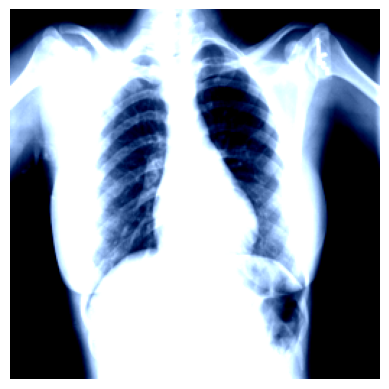

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Projection: Frontal
Generated Report:
the heart normal size the mediastinum unremarkable the lungs are clear acute disease



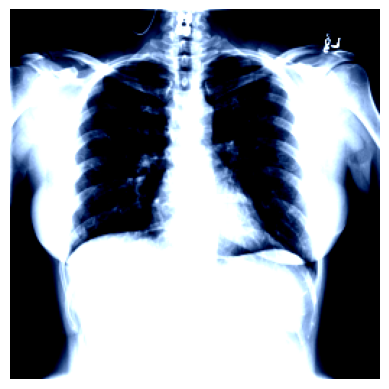

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Projection: Frontal
Generated Report:
heart size normal and lungs are clear



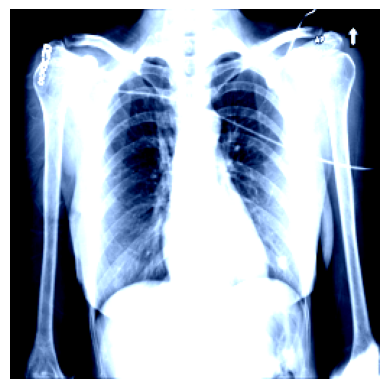

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Projection: Frontal
Generated Report:
heart size normal lungs are clear



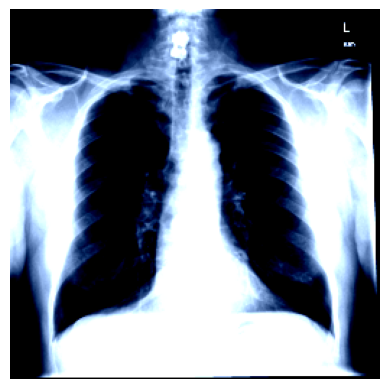

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Projection: Frontal
Generated Report:
the heart and lungs have the interval both lungs are clear and expanded heart and mediastinum normal active disease



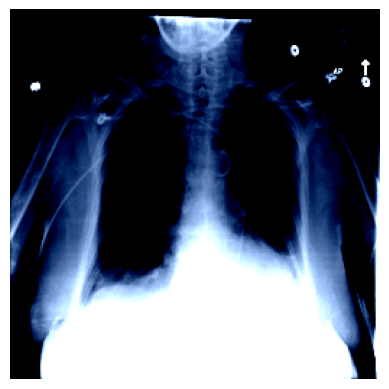

In [ ]:
test_images = [
    ('1_IM-0001-4001.dcm.png', 'Frontal'),
    ('3_IM-1384-1001.dcm.png', 'Frontal'),
    ('21_IM-0729-1001-0001.dcm.png', 'Frontal'),
    ('112_IM-0080-1001.dcm.png', 'Frontal'),
    ('436_IM-2076-1001-0002.dcm.png', 'Frontal'),
    # Add more test cases as needed
]

for img_path, projection in test_images:
    # Prepare image
    image = prepare_image('dataset/images/images_normalized/'+img_path, val_test_transform, device)

    # Encode projection
    projection_idx = train_dataset.projection_to_index.get(projection, len(train_dataset.projection_types))
    projection_tensor = torch.tensor([projection_idx], dtype=torch.long).to(device)

    # Generate report using enhanced beam search with ClinicalBERT embeddings from generated text
    generated_report = generate_caption_beam_search_with_clinicalbert(
        model=cnn_lstm_model,
        image=image,
        projection=projection_tensor,
        index_to_word=index_to_word,
        word_to_index=word_to_index,
        device=device,
        tokenizer=tokenizer,
        max_length=128,
        beam_width=3,
        repetition_penalty=1.5
    )

    print(f"Projection: {projection}")
    print(f"Generated Report:\n{generated_report}\n")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image: 436_IM-2076-1001-0002.dcm.png

Projection: Frontal

Ground Truth Report:
borderline heart size and lungs are clear have expanded heart and mediastinum active disease

Generated Report:
the heart and lungs have the interval both lungs are clear and expanded heart and mediastinum normal active disease

BLEU Score: 0.2281



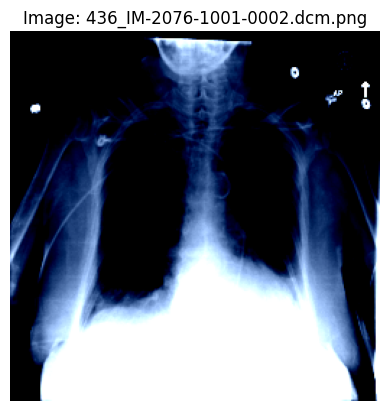

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Test images
test_images = [
    ('436_IM-2076-1001-0002.dcm.png', 'Frontal'),
]

smoothing = SmoothingFunction().method1

# Iterate through test cases
for img_path, projection in test_images:
    # Prepare the image
    image = prepare_image('dataset/images/images_normalized/' + img_path, val_test_transform, device)

    # Encode projection
    projection_idx = train_dataset.projection_to_index.get(projection, len(train_dataset.projection_types))
    projection_tensor = torch.tensor([projection_idx], dtype=torch.long).to(device)

    # Generate the report
    generated_report = generate_caption_beam_search_with_clinicalbert(
        model=cnn_lstm_model,
        image=image,
        projection=projection_tensor,
        index_to_word=index_to_word,
        word_to_index=word_to_index,
        device=device,
        tokenizer=tokenizer,
        max_length=128,
        beam_width=3,
        repetition_penalty=1.5
    )

    # Fetch the ground truth report
    image_index = image_paths.index('dataset/images/images_normalized/' + img_path)
    ground_truth_report = reports_text[image_index]

    # Calculate BLEU score
    bleu_score = sentence_bleu(
        [ground_truth_report.split()],
        generated_report.split(),
        smoothing_function=smoothing
    )

    # Display results
    print(f"Image: {img_path}\n")
    print(f"Projection: {projection}\n")
    print(f"Ground Truth Report:\n{ground_truth_report}\n")
    print(f"Generated Report:\n{generated_report}\n")
    print(f"BLEU Score: {bleu_score:.4f}\n")

    # Show the image
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title(f"Image: {img_path}")
    plt.show()
